# Mongo Querying

Now it is time to load our data into our local mongo instance.

I wanted to do this all with pymongo rather than my command line as that seemed easier to repeat and document.

To get started I had to walk through the pymongo tutorial to learn how to establish a client, database, and collection.

In [3]:
from pymongo import MongoClient
from __future__ import division
import json
import pprint as pp
import matplotlib.pyplot as plt

In [4]:
client = MongoClient()
db = client['san-diego']
col = db['san-diego-map']

Now that we our client, database and collection ready, we will read our `sd.json` file (output from our shaping/cleaning functions before) into a python variable and load it into the collection using `insert_many`

In [204]:
with open('sd.json') as data_file:    
    data = json.load(data_file) 

col.insert_many(data)

Let's test to make sure we have some data by running a simple query.

In [6]:
pp.pprint(col.find_one())

{u'_id': ObjectId('587a7222f431b026b48b5f8f'),
 u'created': {u'changeset': u'551611',
              u'timestamp': u'2008-07-20T10:38:50Z',
              u'uid': u'14293',
              u'user': u'KindredCoda',
              u'version': u'4'},
 u'created_by': u'JOSM',
 u'id': u'28828453',
 u'pos': [u'32.7642168', u'-117.2332461'],
 u'type': u'node'}


Great! Our query returned the expected result, let's start our analysis.

# Analysis

## Number of entries, nodes, and ways

Lets take peak at our `type` field and see what the counts look like for our total entries and its composition between nodes and ways.

We will visualize this with a bar plot, I suspect we will be using a lot of bar graphs so I might as well write a convenience function at this time.

In [7]:
def draw_bar(ind, data, label, x_label, y_label):
    plt.barh(ind, data, tick_label=label, color='c')
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.show()

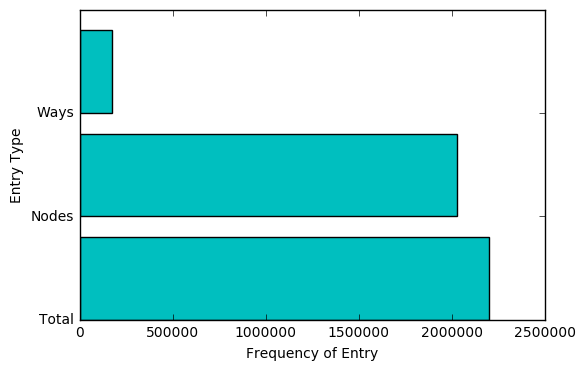

Number of entries:	2199884
Number of nodes:	2024896
Number of ways:	174710


In [207]:
node_query = {'type': 'node'}
way_query = {'type': 'way'}

total_entries = col.find().count()
total_nodes = col.find(node_query).count()
total_ways = col.find(way_query).count()

ind = range(0,3)
data = [total_entries, total_nodes, total_ways]
label = [ 'Total', 'Nodes', 'Ways']
x_label = "Frequency of Entry"
y_label = "Entry Type"

draw_bar(ind, data, label, x_label, y_label)

print "Number of entries:\t{}\nNumber of nodes:\t{}\nNumber of ways:\t{}".\
    format(total_entries, total_nodes, total_ways)

It looks like our nodes vastly outweigh the number of ways but that is to be expected as a way is comprised of several nodes.

## Number of unique users

To find the number of unique users, I am going to run a `.distinct()` query on our `created.user` field and use python's `len()` function to determine the number of rows returned.

In [208]:
def get_unique_count(collection, user_column):
    return len(collection.distinct(user_column))

In [209]:
print "{} distinct users!".format(get_unique_count(col, "created.user"))

953 distinct users!


Looks like we have just under 1,000 unique contributors.

## Top Contributors

Lets take a look at who our top ten contributors are and what proportion of the data they are responsible for

In [210]:
def get_field_counts(collection, field_name, limit=None):
    if limit:
        query = [{"$match": {"{}".format(field_name): {"$exists" : True}}},\
                      {"$group": {"_id": "${}".format(field_name), "count":{"$sum": 1}}},\
                      {"$sort": {"count": -1}},\
                      {"$limit": limit}]
    else:
        query = [{"$match": {"{}".format(field_name): {"$exists" : True}}},\
                      {"$group": {"_id": "${}".format(field_name), "count":{"$sum": 1}}},\
                      {"$sort": {"count": -1}}]
    return collection.aggregate(query)

In [211]:
top_contributors = get_field_counts(col, 'created.user', 10)
proportion_from_top_ten = 0 

for contributor in top_contributors:
    proportion_from_user = contributor['count']/total_entries
    proportion_from_top_ten += proportion_from_user
    print"{:<20}{:>30}{:>30}".format(contributor['_id'], contributor['count'], contributor['count']/total_entries, proportion_from_user)
    
print "\n{} of the entries came from the top ten contibutors".format(proportion_from_top_ten)

n76                                         670346                0.304718794264
Adam Geitgey                                329612                0.149831536572
Sat                                         257028                0.116837069591
woodpeck_fixbot                             183974               0.0836289549813
Zian Choy                                    32644               0.0148389642363
Brian@Brea                                   31862               0.0144834909477
TieFaith                                     26000               0.0118188049915
stevea                                       25314               0.0115069703675
evil saltine                                 24300               0.0110460369729
javbw                                        22064               0.0100296197436

0.728740242667 of the entries came from the top ten contibutors


# Visualize: Contributor Rank and Proportion of Contributions

In [212]:
def draw_pie(data, color_list, labels):
    plt.pie(data, colors=color_list, labels=labels, shadow=True, autopct='%1.2f%%')
    plt.show()

In [213]:
contributors_by_rank = list(get_field_counts(col, 'created.user'))
contributors_by_rank = [x['count'] for x in contributors_by_rank]

proportion_from_top_ten = sum(contributors_by_rank[:10])
proportion_from_next_hundred = sum(contributors_by_rank[10:111])
proportion_from_rest = sum(contributors_by_rank[111:])

data = [proportion_from_top_ten, proportion_from_next_hundred, proportion_from_rest]
colors = ['c', 'y', 'm']
labels = ['Contributors Rank 1 - 10', 'Contributors Rank 11 - 111', 'Remaining Contributors']

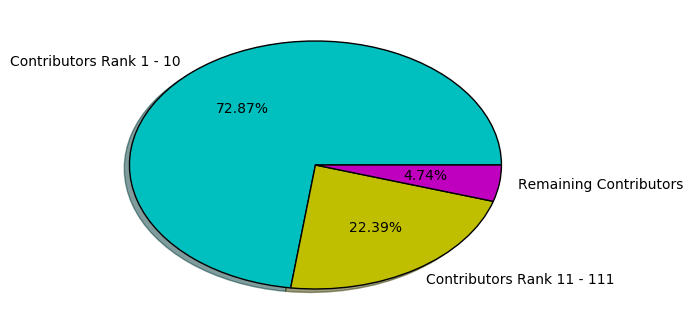

In [214]:
draw_pie(data, colors, labels)

As you can see above, 110 users (or 11.54% of users) account for over 95% of the map's contributions.

## Visualize: Node and Way Contributions amongst Top Ten Contributors

    I was struggling a bit with created the stacked bar chart so I used the documentation page below for some assistance.
    http://matplotlib.org/examples/pylab_examples/bar_stacked.html

In [215]:
def draw_stacked_bar(ind, bar1_data, bar2_data, x_y_labels, legend_tuple, labels):
    p1 = plt.barh(ind, bar1_data, color='y', tick_label=labels)
    p2 = plt.barh(ind, bar2_data, left=bar1_data, color='r', tick_label=labels)
                                                         
    plt.xlabel(x_y_labels[0])    
    plt.ylabel(x_y_labels[1])
    plt.legend((p1[0], p2[0]), legend_tuple)
    
    plt.show()

In [216]:
# Get list of top 10 ranked contributors for match in query
top_ten_usernames = list(get_field_counts(col, 'created.user', limit=10))
top_ten_usernames = [user['_id'] for user in top_ten_usernames]

# Create queries for counting each user's individual node/way contributions
node_query = [{"$match": {"type": "node", "created.user":{"$in": top_ten_usernames}}},\
         {"$group": {"_id": "$created.user", "count": {"$sum": 1}}}]

way_query = [{"$match": {"type": "way", "created.user":{"$in": top_ten_usernames}}},\
         {"$group": {"_id": "$created.user", "count": {"$sum": 1}}}]

ind = range(0,10)

# Query and sort our results so that each user's bar has their node and way contributions adjacent
node_contributions = list(col.aggregate(node_query))
node_contributions = sorted(node_contributions, key=lambda k:k['_id'])

way_contributions = list(col.aggregate(way_query))
way_contributions = sorted(way_contributions, key=lambda k:k['_id'])

x_y_labels = ["Number of Contributions", "Username"]
legend_tuple = ("Node", "Way")

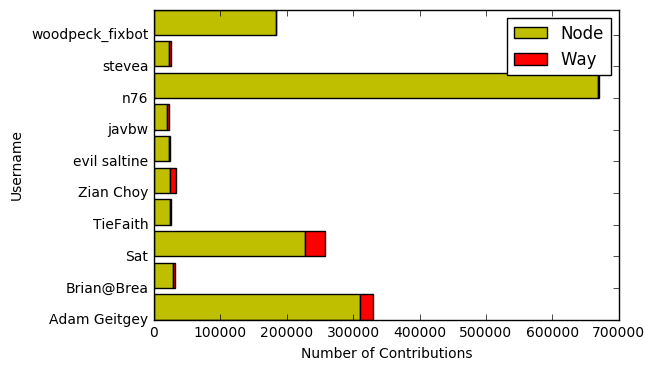

In [217]:
draw_stacked_bar(ind,\
                 [node['count'] for node in node_contributions],\
                 [way['count'] for way in way_contributions],\
                 x_y_labels, legend_tuple,\
                 [node['_id'] for node in node_contributions])

As you can see above, our top contributor, 'n76' doubled the contributions of our second place contributor but was not the highest contributor of 'ways'! 

## Amenities

Now lets take a look at San Diego's Fast Food distribution. I want to answer the following questions: 
- Which franchise has the most locations (as a whole and by cuisine type)?
- What is the most common type of fast food? 

In [152]:
def get_fast_food(collection, limit=None):
    if not limit:
        query = [{"$match": {"amenity": 'fast_food', "name":{"$exists": True}}},\
                {"$group": {"_id": "$name", "count": {"$sum": 1}}},\
                {"$sort": {"count":-1}}]
    else:
        query = [{"$match": {"amenity": 'fast_food', "name":{"$exists": True}}},\
                {"$group": {"_id": "$name", "count": {"$sum": 1}}},\
                {"$sort": {"count":-1}},\
                {"$limit": limit}]
    return collection.aggregate(query)

To get the most commonly occuring fast food franchise, queried for entries with fast_food as the amenity, grouped those that had a name field, added their counts, sorted descending, and limited results to the top 15.

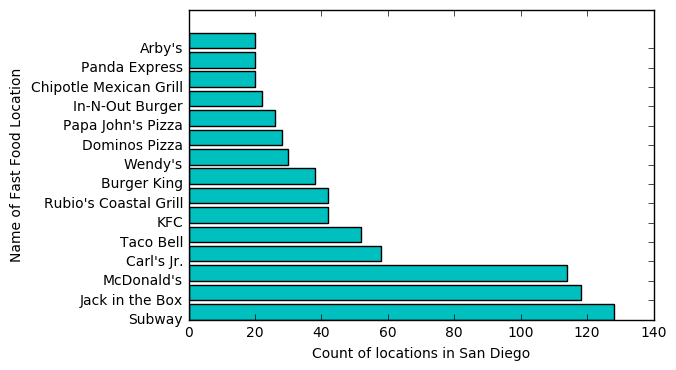

In [218]:
results = list(get_fast_food(col, 15))

ind = range(0, len(results))
data = [ff['count'] for ff in results]
label = [ff['_id'] for ff in results]
x_label = "Count of locations in San Diego"
y_label = "Name of Fast Food Location"

draw_bar(ind, data, label, x_label, y_label)

Looks like **Subway**, the world's most common fast food franchise, also has the most locations in San Diego! Next is San Diego based company, Jack in the Box, I suppose that is not too surprising.

In [219]:
def get_fast_food_cuisine_counts(collection, limit=None):
    if limit:
        query = [\
                {"$match": {"amenity": "fast_food", "cuisine": {"$exists": True}}},\
                {"$unwind": "$cuisine"},\
                {"$group": {"_id": "$cuisine", "count": {"$sum": 1}}},\
                {"$sort": {"count": -1}},\
                {"$limit": limit}]
    else:
        query = [\
            {"$match": {"amenity": "fast_food", "cuisine": {"$exists": True}}},\
            {"$unwind": "$cuisine"},\
            {"$group": {"_id": "$cuisine", "count": {"$sum": 1}}},\
            {"$sort": {"count": -1}}]
    return collection.aggregate(query)

Now that we know that 3 out of the top 5 most common fast food locations are burger joints, let's see if we can't visualize the type of fast food across San Diego.

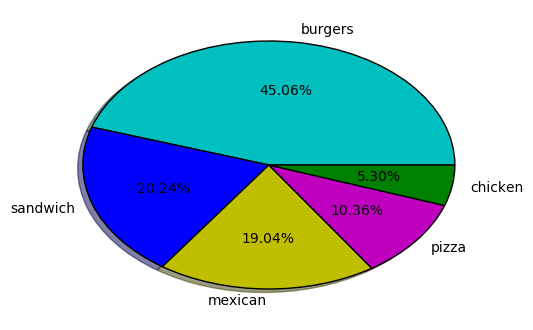

In [220]:
results = list(get_fast_food_cuisine_counts(col, 5))

data = [c['count'] for c in results]
label = [c['_id'] for c in results]

draw_pie(data=data,color_list=['c','b', 'y', 'm', 'g'], labels=label)

Burger joint's account for 45% of San Diego fast food locations! While, 20% are sandwich shops. I am willing to guess that Subway makes up a large portion of that 20% itself while the burger distribution is likely shared amongst Jack, McDonalds, and Carl's Jr.

Let's look at the different fast food franchise by their cuisine type now.

In [9]:
def fast_food_by_type(collection, cuisine_type):
    query = [{"$match" : {\
        "name": {"$exists": True},\
        "cuisine": {"$exists": True}, "cuisine": "{}".format(cuisine_type),\
        "amenity": {"$exists": True}, "amenity": "fast_food"}},\
    {"$group": {"_id": "$name", "count": {"$sum": 1}}},\
    {"$sort": {"count": -1}}]
    return collection.aggregate(query)

In [10]:
burger_data = list(fast_food_by_type(col, 'burgers'))
sandwich_data = list(fast_food_by_type(col, 'sandwich'))
mexican_data = list(fast_food_by_type(col, 'mexican'))
pizza_data = list(fast_food_by_type(col, 'pizza'))
chicken_data = list(fast_food_by_type(col, 'chicken'))

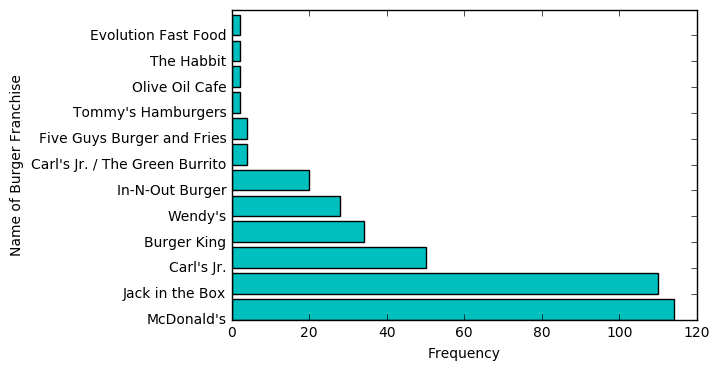

In [11]:
ind = range(0, len(burger_data))
draw_bar(ind, [item['count'] for item in burger_data], label=[item['_id'] for item in burger_data], x_label="Frequency", y_label="Name of Burger Franchise")

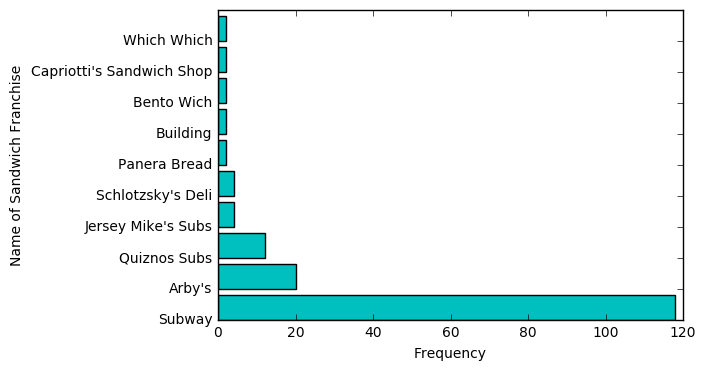

In [12]:
ind = range(0, len(sandwich_data))
data = [item['count'] for item in sandwich_data]
label =  [item['_id'] for item in sandwich_data]
xlab = "Frequency"
ylab = "Name of Sandwich Franchise"

draw_bar(ind, data, label, xlab, ylab)

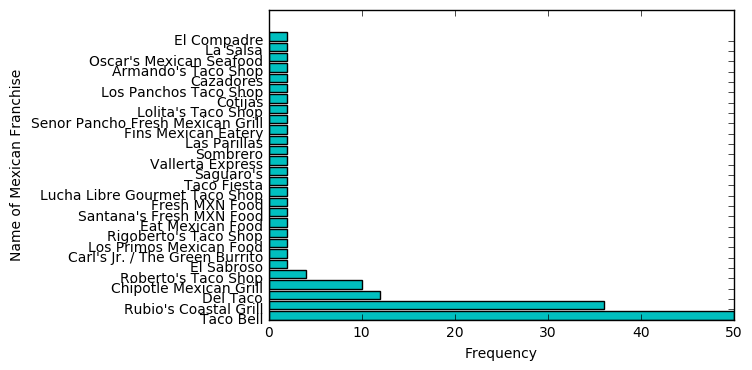

In [13]:
ind = range(0, len(mexican_data))
data = [item['count'] for item in mexican_data]
label =  [item['_id'] for item in mexican_data]
xlab = "Frequency"
ylab = "Name of Mexican Franchise"

draw_bar(ind, data, label, xlab, ylab)

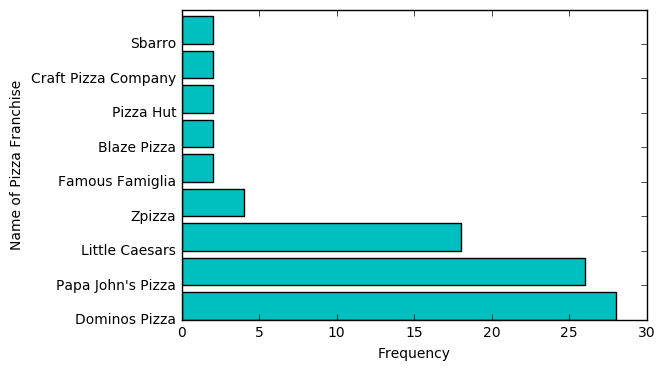

In [14]:
ind = range(0, len(pizza_data))
data = [item['count'] for item in pizza_data]
label =  [item['_id'] for item in pizza_data]
xlab = "Frequency"
ylab = "Name of Pizza Franchise"

draw_bar(ind, data, label, xlab, ylab)

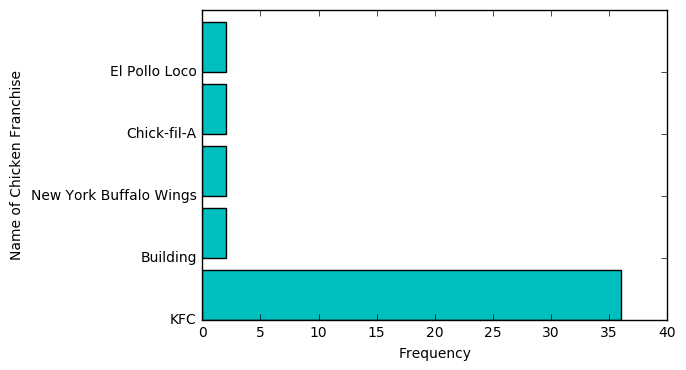

In [15]:
ind = range(0, len(chicken_data))
data = [item['count'] for item in chicken_data]
label =  [item['_id'] for item in chicken_data]
xlab = "Frequency"
ylab = "Name of Chicken Franchise"

draw_bar(ind, data, label, xlab, ylab)

It looks like our burger and pizza franchises have a few top competitors while sandwich and chicken shops are vastly outnumbered by Subway and KFC.

Mexican eateries have many different franchises but also have high frequencies of Taco Bell, Del Taco, and Rubios'.

I noticed that 'Building' had 3 locations in our chicken category. I have never heard of a franchise name 'Building' so I decided to query for fast food with name == 'Building' and search for their coordinates on Google Maps. I found that each of these lat, lon strings coordinated with an empty fast food retail location on Rosecrans Street near Point Loma. It was unclear if these are marked as potential or previous chicken fast food locations.

## Religious Affiliation

I wanted to take a peak at the different types of churches in San Diego but after getting the types of churches and frequency it was overwhelmingly Christian (1750 out of 1812)